# Установка необходимых библиотек #

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, DatetimeTickFormatter, Band
from bokeh.layouts import gridplot
import pandas as pd
from datetime import datetime, timedelta
from bokeh.models import HoverTool, DatetimeTickFormatter, Band, ColumnDataSource
import pandas_ta as ta

# Подключение к БД #

In [2]:
# Настройки подключения к БД
host='...'
username='...'
password='...'
database_name='...'

# Создаем подключение
connection_string = f'mysql+pymysql://{username}:{password}@{host}/{database_name}'
engine = create_engine(connection_string)

# Выполнение SQL-запроса и сохранение результатов в датафрейме
sql_query = """
SELECT *
FROM market_data
"""
df = pd.read_sql(sql_query, engine)

# Основные статистики #

In [4]:
df.info()
# Пропусков нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2943 entries, 0 to 2942
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   open              2943 non-null   float64       
 1   high              2943 non-null   float64       
 2   low               2943 non-null   float64       
 3   close             2943 non-null   float64       
 4   adj_close         2943 non-null   float64       
 5   volume            2943 non-null   int64         
 6   ticker            2943 non-null   object        
 7   asset_name        2943 non-null   object        
 8   business_date     2943 non-null   object        
 9   created_datetime  2943 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1), object(3)
memory usage: 230.1+ KB


In [7]:
df.describe()

,open,high,low,close,adj_close,volume,created_datetime
count,2943.000000,2943.000000,2943.000000,2943.000000,2943.000000,2.943000e+03,2943
mean,248.913354,251.065831,246.624658,248.930598,246.154568,3.296560e+07,2024-12-05 18:18:30.000000512
min,66.279999,67.699997,63.639999,65.750000,65.750000,0.000000e+00,2024-12-05 18:18:30
25%,82.459999,83.329998,81.384998,82.439999,82.439999,5.978550e+04,2024-12-05 18:18:30
50%,124.660004,133.130005,121.370003,123.699997,123.699997,7.890410e+05,2024-12-05 18:18:30
75%,411.910004,414.104996,409.490005,412.275009,402.720352,6.148230e+07,2024-12-05 18:18:30
max,605.630005,607.909973,604.950012,607.659973,607.659973,2.517839e+08,2024-12-05 18:18:30
std,173.655036,174.239206,172.971001,173.694043,171.265506,3.857124e+07,NaN


In [8]:
df.describe(include = 'object')

,ticker,asset_name,business_date
count,2943,2943,2943
unique,4,4,737
top,BZ=F,BRENT,2022-01-03
freq,737,737,4


In [11]:
df = df.set_index("business_date")

                 WTI  Nasdaq-100     BRENT   S&P 500
WTI         1.000000   -0.437241  0.991310 -0.418689
Nasdaq-100 -0.437241    1.000000 -0.485653  0.983934
BRENT       0.991310   -0.485653  1.000000 -0.465244
S&P 500    -0.418689    0.983934 -0.465244  1.000000


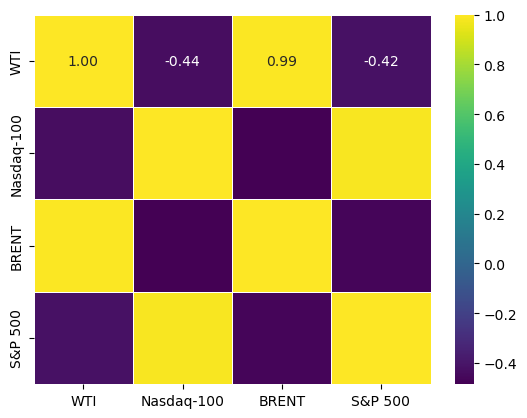

In [20]:
corr = pd.DataFrame({
    "WTI": df[df['asset_name'] == 'WTI']["close"],
    "Nasdaq-100": df[df['asset_name'] == 'Nasdaq-100']["close"],
    "BRENT": df[df['asset_name'] == 'BRENT']["close"],
    "S&P 500": df[df['asset_name'] == 'S&P 500']["close"]
})


print(corr.corr())

# Вычисляем корреляционную матрицу только 
if not corr.empty:
    correlation_matrix = corr.corr(numeric_only=True)
    sns.heatmap(correlation_matrix,
               linewidths=0.5,
               annot=True,
               cmap='viridis',
               fmt=".2f",
               annot_kws={'size': 10})
    plt.show()

*Сильная корреляция между WTI и Brent*

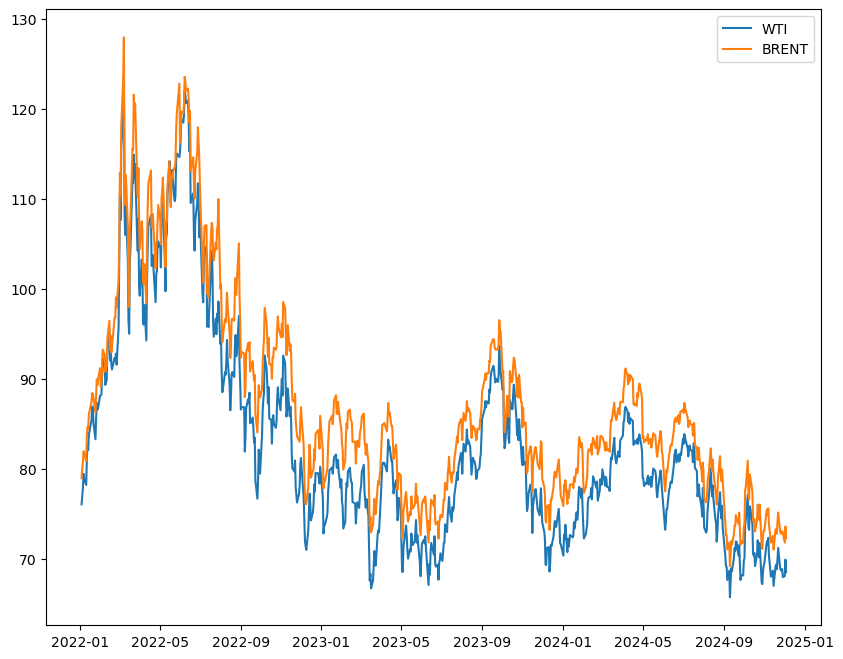

In [22]:
plt.figure(figsize=(10, 8))
plt.plot(df[df['asset_name'] == 'WTI']["close"])
plt.plot(df[df['asset_name'] == 'BRENT']["close"])
plt.legend(["WTI", "BRENT"])

## Разделим датасет на 4 группы по типам рассчитываемых показателей ##

In [85]:
WTI = df[df['asset_name'] == 'WTI']
Nasdaq = df[df['asset_name'] == 'Nasdaq-100']
BRENT = df[df['asset_name'] == 'BRENT']
SP500 = df[df['asset_name'] == 'S&P 500']

# Расчет показателей при помощи библиотеки pandas_ta #  

## RSI ## 
Индикатор RSI показывает силу тренда и вероятность его смены (https://ru.tradingview.com/chart/BTCUSD/Eq8tysZA-indikator-rsi-sekrety-torgovli-pravila-primeneniya-polnyj-razbor/):

- *Если значение индикатора поднимается к 70 и выше - актив перекуплен и входить в покупки сейчас неблагоразумно, а еще лучше - нужно выходить из актива*/   

- *Если значение индикатора опускается ниже 30 - актив перепродан и вы рискуете продать его на самом дне. Это хорошая возможность, чтобы рассматривать покупки*/

Еще один дополнительный сигнал от индикатора RSI - определение направления текущей тенденции.    Принято считать, что если значение индикатора пересекает отметку в 50 - то тренд меняется. Довольно часто можно заметить, как при сильных трендах цена находит поддержку/сопротивление на этом уровне.

📊НАХОЖДЕНИЕ ДИВЕРГЕНЦИИ  

Один из самых надежных методов торговли, используя индикатор RSI. Дивергенция - это момент расхождения значений индикатора и цены, которая намекает на скорую смену тенденции в сторону направления значения индикатора.   

In [87]:
WTI.loc[:, 'rsi'] = ta.rsi(WTI['close'], timeperiod=14)
Nasdaq.loc[:, 'rsi'] = ta.rsi(Nasdaq['close'], timeperiod=14)
BRENT.loc[:, 'rsi'] = ta.rsi(BRENT['close'], timeperiod=14)
SP500.loc[:, 'rsi'] = ta.rsi(SP500['close'], timeperiod=14)

## SMA, EMA, WMA, DEMA, TEMA  ##
Скользящие средние — это технические индикаторы, используемые в техническом анализе для сглаживания колебаний цен актива и выявления основных трендов. Они рассчитываются путем усреднения цен различными способами за определенный период времени.

In [89]:
# SMA 30 дней
WTI.loc[:, 'sma'] = ta.sma(WTI['close'], length=30)
Nasdaq.loc[:, 'sma'] = ta.sma(Nasdaq['close'], length=30)
BRENT.loc[:, 'sma'] = ta.sma(BRENT['close'], length=30)
SP500.loc[:, 'sma'] = ta.sma(SP500['close'], length=30)
# EMA
WTI.loc[:, 'ema'] = ta.ema(WTI['close'], length=30)
Nasdaq.loc[:, 'ema'] = ta.ema(Nasdaq['close'], length=30)
BRENT.loc[:, 'ema'] = ta.ema(BRENT['close'], length=30)
SP500.loc[:, 'ema'] = ta.ema(SP500['close'], length=30)
# WMA
WTI.loc[:, 'wma'] = ta.wma(WTI['close'], length=30)
Nasdaq.loc[:, 'wma'] = ta.wma(Nasdaq['close'], length=30)
BRENT.loc[:, 'wma'] = ta.wma(BRENT['close'], length=30)
SP500.loc[:, 'wma'] = ta.wma(SP500['close'], length=30)

# DEMA
WTI.loc[:, 'dema'] = ta.dema(WTI['close'], length=30)
Nasdaq.loc[:, 'dema'] = ta.dema(Nasdaq['close'], length=30)
BRENT.loc[:, 'dema'] = ta.dema(BRENT['close'], length=30)
SP500.loc[:, 'dema'] = ta.dema(SP500['close'], length=30)
# TEMA
WTI.loc[:, 'tema'] = ta.tema(WTI['close'], length=30)
Nasdaq.loc[:, 'tema'] = ta.tema(Nasdaq['close'], length=30)
BRENT.loc[:, 'tema'] = ta.tema(BRENT['close'], length=30)
SP500.loc[:, 'tema'] = ta.tema(SP500['close'], length=30)

## Визуализация для марки нефти WTI ##

In [31]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import HoverTool, Legend, DatetimeTickFormatter
from datetime import datetime
from datetime import timedelta
output_notebook() 

# Создаем фигуру
p = figure(width=1000, height=600,
           tools="pan,wheel_zoom,box_select,reset,hover",
           title="График RSI, Close и SMA",
           x_axis_type="datetime")  


rsi_line = p.line(x=WTI.index, y=WTI["rsi"], legend_label="RSI", line_color="blue")
ohls_line = p.line(x=WTI.index, y=WTI["close"], legend_label="OHLS", line_color="orange")
sma_line = p.line(x=WTI.index, y=WTI["sma"], legend_label="SMA", line_color="green")

date_19350 = datetime(2022, 1, 1)
date_19750 = datetime(2025, 1, 1)


p.line([date_19350, date_19750], [70, 70], line_dash='dashed', line_color='red', legend_label="Верхняя граница")
p.line([date_19350, date_19750], [50, 50], line_dash='dashed', line_color='blue', legend_label="Середина")
p.line([date_19350, date_19750], [30, 30], line_dash='dashed', line_color='green', legend_label="Нижняя граница")


legend = Legend(items=[
    ("RSI", [rsi_line]),
    ("Close", [ohls_line]),
    ("SMA", [sma_line]),
    ("Верхняя граница", []),
    ("Нижняя граница", [])
])
p.add_layout(legend, 'right')

# Настраиваем инструмент hover
hover = p.select_one(HoverTool)
hover.tooltips = [
    ('Дата', '@x{%F}'),
    ('Значение', '@y')
]
hover.formatters = {
    '@x': 'datetime'
}

# Форматируем ось X
p.xaxis.formatter = DatetimeTickFormatter(days="%d-%m-%Y", months="%d-%m-%Y", years="%d-%m-%Y")

# Показываем график
show(p)

Loading BokehJS ...

## MACD и Stochastic##
MACD — это индикатор, который отсеивает незначительные краткосрочные движения цены и позволяет купить или продать актив на первых этапах нового тренда.
Stochastic — это индикатор, который показывает, насколько текущая цена выбранного актива близка к своим максимумам или минимумам за установленный период. Благодаря Stochastic инвесторы могут быстро заметить смену тренда  с восходящего на нисходящий или наоборот 

In [91]:
def calculate_indicators(df, fast_period=12, slow_period=26, signal_period=9, stoch_k_period=14, stoch_d_period=3):
    df.loc[:,'MACD'] = ta.macd(df['close'], fast=fast_period, slow=slow_period, signal=signal_period)['MACD_12_26_9']
    df.loc[:,'MACD_Signal'] = ta.macd(df['close'], fast=fast_period, slow=slow_period, signal=signal_period)['MACDs_12_26_9']
    df.loc[:,'Stochastic_K'] = ta.stoch(df['high'], df['low'], df['close'], k=stoch_k_period, d=stoch_d_period)['STOCHk_14_3_3']
    df.loc[:,'Stochastic_D'] = ta.stoch(df['high'], df['low'], df['close'], k=stoch_k_period, d=stoch_d_period)['STOCHd_14_3_3']
    return df

WTI = calculate_indicators(WTI)
Nasdaq = calculate_indicators(Nasdaq)
BRENT = calculate_indicators(BRENT)
SP500 = calculate_indicators(SP500)

In [49]:
WTI.loc[:,'date'] = pd.to_datetime(WTI.index)
source = ColumnDataSource(data=WTI.to_dict('list'))

# Графики
p1 = figure(width=800, height=300, title="close", x_axis_type="datetime")
p2 = figure(width=800, height=300, title="Stochastic %K & %D", x_axis_type="datetime", x_range=p1.x_range)

# Первый график
p1.line(x='date', y='close', source=source, legend_label="close", line_color="orange")

# Второй график
p2.line(x='date', y='Stochastic_K', source=source, line_dash='dashed', legend_label="%K", line_color="blue")
p2.line(x='date', y='Stochastic_D', source=source, legend_label="%D", line_color="green")

# Полосы для Stochastic
band = Band(lower=20, upper=80, fill_color='lightgreen', fill_alpha=0.2)
p2.add_layout(band)

# HoverTool
hover = HoverTool(tooltips=[("Дата", "@date{%F}")], formatters={"@date": "datetime"})
p1.add_tools(hover)
p2.add_tools(hover)

# Форматирование осей
p1.xaxis.formatter = DatetimeTickFormatter(days="%d-%m-%Y")
p2.xaxis.formatter = DatetimeTickFormatter(days="%d-%m-%Y")
p2.xaxis.major_label_orientation = "vertical"

# Компоновка
grid = gridplot([[p1], [p2]], toolbar_location="left")

# Отображение
show(grid)
WTI.drop(columns = ['date'], inplace = True)

C:\Users\User\AppData\Local\Temp\ipykernel_12480\406269261.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WTI.loc[:,'date'] = pd.to_datetime(WTI.index)


C:\Users\User\AppData\Local\Temp\ipykernel_12480\406269261.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WTI.drop(columns = ['date'], inplace = True)


## CCI, %R, ROC, MOM ##
CCI (Commodity Channel Index): Индекс товарного канала.\
Williams %R: Индикатор Уильямса %R.\
ROC (Rate of Change): Темп изменения.\
MOM (Momentum): Момент.

In [93]:
def calculate_indicators(df, period=14, date_format='%Y-%m-%d'): # добавили date_format
    df.index = pd.to_datetime(df.index, format=date_format) # Укажите ваш формат даты!
    df.loc[:,'CCI'] = ta.cci(df['high'], df['low'], df['close'], length=period)
    df.loc[:,'Williams_R'] = ta.willr(df['high'], df['low'], df['close'], length=period)
    df.loc[:,'ROC'] = ta.roc(df['close'], length=period)
    df.loc[:,'MOM'] = ta.mom(df['close'], length=period)
    return df

# Применение функции к каждому DataFrame
WTI = calculate_indicators(WTI)
Nasdaq = calculate_indicators(Nasdaq)
BRENT = calculate_indicators(BRENT)
SP500 = calculate_indicators(SP500)

## Объемные индикаторы (Volume Indicators) ##

Эти индикаторы анализируют объем торговли для подтверждения ценовых трендов\
OBV (On-Balance Volume): Баланс объема.\
MFI (Money Flow Index): Индекс денежного потока.

In [98]:
def calculate_volume(df, period=14):
    df.loc[:,'OBV'] = ta.obv(df['close'], df['volume'])
    df.loc[:,'MFI'] = ta.mfi(df['high'], df['low'], df['close'], df['volume'], length=period)
    return df

WTI = calculate_indicators(WTI)
Nasdaq = calculate_indicators(Nasdaq)
BRENT = calculate_indicators(BRENT)
SP500 = calculate_indicators(SP500)

## Индикаторы волатильности (Volatility Indicators) ##
ATR (Average True Range): Средний истинный диапазон.\
Bollinger Bands: Полосы Боллинджера.

In [104]:
def calculate_indicators(df, period=14, bb_length=20, bb_std=2): # period для ATR, bb_length и bb_std для Bollinger Bands
    df.loc[:,'ATR'] = ta.atr(df['high'], df['low'], df['close'], length=period)
    bbands_results = ta.bbands(df['close'], length=bb_length, std=bb_std)
    df.loc[:,'BB_upper'] = bbands_results['BBU_' + str(bb_length) + '_' + str(bb_std) + '.0']
    df.loc[:,'BB_middle'] = bbands_results['BBM_' + str(bb_length) + '_' + str(bb_std) + '.0']
    df.loc[:,'BB_lower'] = bbands_results['BBL_' + str(bb_length) + '_' + str(bb_std) + '.0']
    return df

WTI = calculate_indicators(WTI)
Nasdaq = calculate_indicators(Nasdaq)
BRENT = calculate_indicators(BRENT)
SP500 = calculate_indicators(SP500)

## Добавим лаги цен ##

In [115]:
def add_specific_lag(df, column_name, lag_period):
    df.loc[:,f'{column_name}_lag{lag_period}'] = df[column_name].shift(lag_period)
    return df

In [116]:
lags = [3,5,10,30,60]
for i in lags:
    WTI = add_specific_lag(WTI, 'close', i)
    Nasdaq = add_specific_lag(Nasdaq, 'close', i)
    BRENT = add_specific_lag(BRENT, 'close', i)
    SP500 = add_specific_lag(SP500, 'close', i)

# Объединим полученные датасеты и загрузим их в БД #

In [130]:
df_list = [WTI, Nasdaq, BRENT, SP500]
result = pd.concat(df_list)

In [136]:
WTI.columns

Index(['open', 'high', 'low', 'close', 'adj_close', 'volume', 'ticker',
       'asset_name', 'created_datetime', 'rsi', 'sma', 'ema', 'wma', 'dema',
       'tema', 'MACD', 'MACD_Signal', 'Stochastic_K', 'Stochastic_D', 'CCI',
       'Williams_R', 'ROC', 'MOM', 'ATR', 'BB_upper', 'BB_middle', 'BB_lower',
       'close_lag5', 'close_lag3', 'close_lag10', 'close_lag30',
       'close_lag60'],
      dtype='object')

In [139]:
result

,open,high,low,close,adj_close,volume,ticker,asset_name,created_datetime,rsi,...,MOM,ATR,BB_upper,BB_middle,BB_lower,close_lag5,close_lag3,close_lag10,close_lag30,close_lag60
business_date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,75.690002,76.459999,74.269997,76.080002,76.080002,317628,CL=F,WTI,2024-12-05 18:18:30,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-04,76.019997,77.639999,75.699997,76.989998,76.989998,372848,CL=F,WTI,2024-12-05 18:18:30,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-05,77.180000,78.580002,76.510002,77.849998,77.849998,397898,CL=F,WTI,2024-12-05 18:18:30,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-06,77.239998,80.239998,76.730003,79.459999,79.459999,476665,CL=F,WTI,2024-12-05 18:18:30,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,76.080002,NaN,NaN,NaN
2022-01-07,79.620003,80.470001,78.519997,78.900002,78.900002,414434,CL=F,WTI,2024-12-05 18:18:30,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,76.989998,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-27,600.460022,600.849976,597.280029,598.830017,598.830017,34000200,SPY,S&P 500,2024-12-05 18:18:30,63.168311,...,3.220032,5.544119,609.909624,589.906003,569.902382,590.500000,595.510010,597.190002,582.299988,550.950012
2024-11-29,599.659973,603.349976,599.380005,602.549988,602.549988,30177400,SPY,S&P 500,2024-12-05 18:18:30,66.415882,...,4.359985,5.470965,609.772126,591.601501,573.430877,593.669983,597.530029,593.349976,582.349976,549.609985
2024-12-02,602.969971,604.320007,602.469971,603.630005,603.630005,31746000,SPY,S&P 500,2024-12-05 18:18:30,67.316905,...,4.869995,5.212327,609.476994,593.231003,576.985011,595.510010,600.650024,585.750000,584.590027,540.359985


In [134]:
result.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2943 entries, 2022-01-03 to 2024-12-04
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   open              2943 non-null   float64       
 1   high              2943 non-null   float64       
 2   low               2943 non-null   float64       
 3   close             2943 non-null   float64       
 4   adj_close         2943 non-null   float64       
 5   volume            2943 non-null   int64         
 6   ticker            2943 non-null   object        
 7   asset_name        2943 non-null   object        
 8   created_datetime  2943 non-null   datetime64[ns]
 9   rsi               2887 non-null   float64       
 10  sma               2827 non-null   float64       
 11  ema               2827 non-null   float64       
 12  wma               2827 non-null   float64       
 13  dema              2827 non-null   float64       
 14  tema  

In [143]:
# Настройки подключения к БД (из вашего кода)
table_name = 'feature_data' # Имя таблицы для сохранения данных

try:
    with engine.begin() as connection: # Используем контекстный менеджер
        result.to_sql(table_name, connection, if_exists='replace', index=True)
    print(f"Данные успешно загружены в таблицу '{table_name}'.")
except Exception as e:
    print(f"Ошибка при загрузке данных в базу данных: {e}")
finally:
    engine.dispose() # Закрываем соединение с базой данных

Данные успешно загружены в таблицу 'feature_data'.
